<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase2/Experiments/Embedding_As_Feature/GPT_Embedding_As_Feature/SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 999 # 'raygx/GNePT-NepSA' is fine-tuned with rand_seed 999

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00


# Loading Model and Tokenizer

In [2]:
from transformers import PreTrainedTokenizerFast
import datasets

model_id = 'raygx/GNePT-NepSA'##'raygx/Nepali-GPT2-CausalLM'
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_id,padding_side='left')
tokenizer

PreTrainedTokenizerFast(name_or_path='raygx/GNePT-NepSA', vocab_size=50000, model_max_length=512, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [25]:
from transformers import AutoConfig, TFAutoModelForSequenceClassification
from transformers import BertTokenizerFast

config = AutoConfig.from_pretrained(
          model_id,
          bos_token_id=tokenizer.cls_token_id,
          eos_token_id=tokenizer.sep_token_id,
          pad_token_id=tokenizer.pad_token_id,
          id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
          label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}
        )

print("Loading Model",model_id)
try:
  model = TFAutoModelForSequenceClassification.from_pretrained(model_id,config = config,revision='a945e5cb4e6c10b2a6c11d3df2103702715f8886')
except:
  print("loading pytorch model")
  model = TFAutoModelForSequenceClassification.from_pretrained(model_id,config = config,from_pt=True)
model.resize_token_embeddings(len(tokenizer))

Loading Model raygx/GNePT-NepSA


All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

All the layers of TFGPT2ForSequenceClassification were initialized from the model checkpoint at raygx/GNePT-NepSA.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2ForSequenceClassification for predictions without further training.


In [26]:
print(model.config)
print(model.summary())

GPT2Config {
  "_name_or_path": "raygx/GNePT-NepSA",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2ForSequenceClassification"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 1,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 3,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    

In [27]:
from transformers import create_optimizer, AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=1e-5, weight_decay_rate=0.01)
model.compile(optimizer=optimizer)

# Data Loading and Preparation

In [28]:
print("#######################Using NepCov19Tweets#########################")
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

#######################Using NepCov19Tweets#########################


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [29]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [30]:
def prepareLabels(row):
    if row['label'] == -1:
        row['label'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

print(data)

Map (num_proc=4):   0%|          | 0/33232 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/8309 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})


In [31]:
data.filter(lambda x: x['label']==0),data.filter(lambda x: x['label']==1),data.filter(lambda x: x['label']==2)

Filter:   0%|          | 0/33232 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8309 [00:00<?, ? examples/s]

Filter:   0%|          | 0/33232 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8309 [00:00<?, ? examples/s]

Filter:   0%|          | 0/33232 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8309 [00:00<?, ? examples/s]

(DatasetDict({
     train: Dataset({
         features: ['label', 'text'],
         num_rows: 10398
     })
     test: Dataset({
         features: ['label', 'text'],
         num_rows: 2556
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['label', 'text'],
         num_rows: 11923
     })
     test: Dataset({
         features: ['label', 'text'],
         num_rows: 3066
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['label', 'text'],
         num_rows: 10911
     })
     test: Dataset({
         features: ['label', 'text'],
         num_rows: 2687
     })
 }))

In [32]:
import tensorflow as tf

class GPTEmbedding(tf.keras.layers.Layer):
    def __init__(self, model,tokenizer, max_token_len=128,padding='max_length', trailing_context=4,truncation=True):
        super().__init__()
        self.embedding = model
        self.tokenizer = tokenizer
        self.tokenizer.padding_side = 'left'
        self.max_token = max_token_len
        self.padding = padding
        self.truncation = truncation
        self.trailing_context = trailing_context
        self.trainable=False

    def call(self, x):
        embeddings = self.embedding(
                      self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf')
                    )[0][:,-self.trailing_context:,:]

        return tf.reduce_logsumexp(embeddings,axis=1)



In [33]:
# model.bert(tokenizer('बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको',padding='max_length',truncation=True,return_tensors='tf',max_length=128))
embd = GPTEmbedding(model.transformer,tokenizer,max_token_len=100,trailing_context=2)
x = embd(["",'बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको','बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको'])
print(x)
model_dim = x.shape[1]

tf.Tensor(
[[ 2.8211002   0.35598528  0.555363   ... -0.5170272  -1.2976627
   4.052132  ]
 [ 2.667098    0.18368179  0.551079   ... -0.2275961  -2.1851976
   4.2831016 ]
 [ 2.667098    0.18368179  0.551079   ... -0.2275961  -2.1851976
   4.2831016 ]], shape=(3, 768), dtype=float32)


In [34]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data,model_dim, batch_size=32,shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.data = data
        self.embeddings = np.empty((data.num_rows,model_dim))
        self.shuffle = shuffle
        # self.average = tf.keras.layers.Average()
        self.is_first_epoch = True
        self.on_epoch_end(is_first_epoch=self.is_first_epoch)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.data.num_rows / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        return self.__data_generation(indexes)

    def on_epoch_end(self,is_first_epoch=False):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.data.num_rows)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

        self.is_first_epoch = is_first_epoch


    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        chunk = self.data.select(indexes)

        if self.is_first_epoch:
          X = embd(chunk['text'])
          self.embeddings[indexes] = X
        else:
          X = self.embeddings[indexes]

        y = np.array(chunk['label'])
        return X,y

In [35]:
%%time

train_features = DataGenerator(data['train'],model_dim=model_dim,batch_size=64)
test_features = DataGenerator(data['test'],model_dim=model_dim,shuffle=False)

CPU times: user 422 µs, sys: 678 µs, total: 1.1 ms
Wall time: 1.57 ms


# Model Specification

In [36]:
sa_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(768)),
    tf.keras.layers.Dense(768,activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(3,activation='softmax')
])

In [37]:
sa_model.compile(
  optimizer=tf.keras.optimizers.Adam(
        learning_rate=5e-4,
        weight_decay=0.1
      ),
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

sa_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 768)               590592    
                                                                 
 dropout_113 (Dropout)       (None, 768)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 2307      
                                                                 
Total params: 592,899
Trainable params: 592,899
Non-trainable params: 0
_________________________________________________________________


## Training

In [38]:
%%time
history = sa_model.fit(train_features,
        epochs=30,
        validation_data=test_features,
        callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_acc', patience=2,
                            verbose=1, mode='max',
                            restore_best_weights=True)
                        ])

Epoch 1/30
520/520 [==============================] - 313s 600ms/step - loss: 0.5287 - acc: 0.8018 - val_loss: 0.4740 - val_acc: 0.8185
Epoch 2/30
520/520 [==============================] - 5s 9ms/step - loss: 0.4844 - acc: 0.8128 - val_loss: 0.4668 - val_acc: 0.8224
Epoch 3/30
520/520 [==============================] - 5s 9ms/step - loss: 0.4849 - acc: 0.8115 - val_loss: 0.4710 - val_acc: 0.8178
Epoch 4/30
520/520 [==============================] - 4s 8ms/step - loss: 0.4808 - acc: 0.8127 - val_loss: 0.4684 - val_acc: 0.8185
Epoch 4: early stopping
CPU times: user 3min 29s, sys: 7.5 s, total: 3min 36s
Wall time: 5min 37s


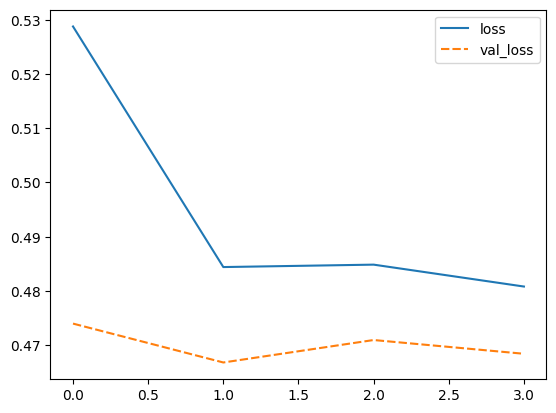

<Axes: >

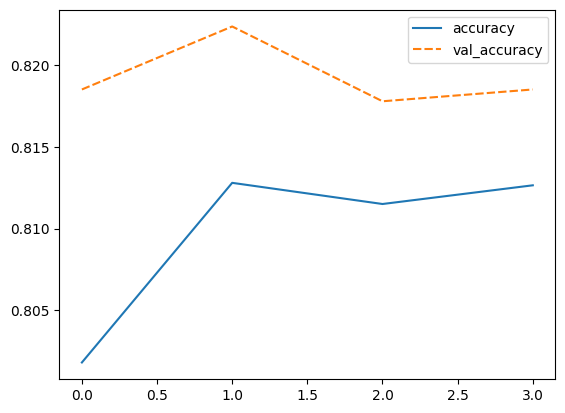

In [41]:
import seaborn
from matplotlib import pyplot as plt

seaborn.lineplot({"loss":history.history['loss'],"val_loss":history.history['val_loss']})
plt.show()

seaborn.lineplot({"accuracy":history.history['acc'],"val_accuracy":history.history['val_acc']})

### Evaluation

In [42]:
%%time

prediction = sa_model.predict(test_features)
prediction = [np.argmax(x) for x in prediction]
actual_labels = data['test']['label']

260/260 [==============================] - 1s 5ms/step
CPU times: user 1.53 s, sys: 65.3 ms, total: 1.59 s
Wall time: 2.7 s


**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [43]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,prediction))

F1-Score 0.8226365094532663
Precision-Score 0.8248880948659819
Recall-Score 0.8223612949813456
accuracy_Score 0.8223612949813456


**Plotting Confusion Matrix**

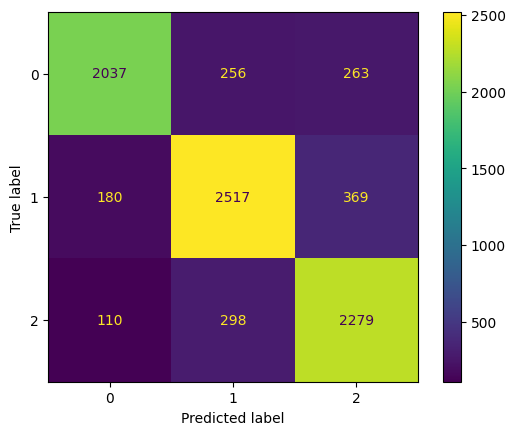

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,prediction,num_classes=3).numpy())
cmd.plot()